<a href="https://colab.research.google.com/github/fgsantosti/topicos_especiais_desenvolvimento/blob/main/An%C3%A1lise_de_Dados_%E2%80%94_E_commerce_no_Brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

orders = pd.read_csv('orders.csv', parse_dates=['data_pedido'])
customers = pd.read_csv('customers.csv')
products = pd.read_csv('products.csv')
order_items = pd.read_csv('order_items.csv')

## Qual é a evolução da receita ao longo do tempo? Há sazonalidade (ex.: Black Friday)?

In [9]:
# Valor líquido
orders['valor_liquido'] = orders['valor_bruto'] - orders['desconto']

# Agregado mensal
orders['mes'] = orders['data_pedido'].dt.to_period('M').dt.to_timestamp()
receita_mensal = (orders.groupby('mes')['valor_liquido']
                          .sum()
                          .reset_index()
                          .sort_values('mes'))

# Número de pedidos por mês (para contexto de volume)
pedidos_mensal = (orders.groupby('mes')['id_pedido']
                         .nunique()
                         .reset_index(name='num_pedidos'))
df_mensal = receita_mensal.merge(pedidos_mensal, on='mes', how='left')
df_mensal.head()

,mes,valor_liquido,num_pedidos
0,2024-01-01,186135.34,85
1,2024-02-01,262390.66,97
2,2024-03-01,289193.53,105
3,2024-04-01,258817.58,95
4,2024-05-01,282539.47,101


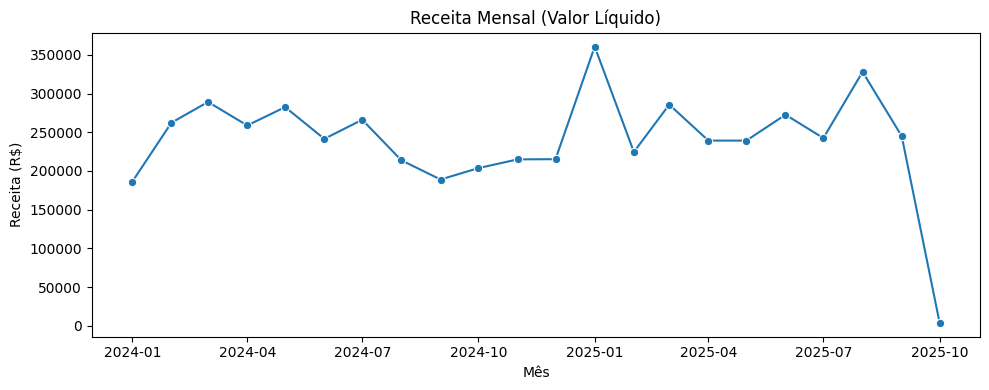

In [10]:
plt.figure(figsize=(10,4))
ax = sns.lineplot(data=df_mensal, x='mes', y='valor_liquido', marker='o')
ax.set_title('Receita Mensal (Valor Líquido)')
ax.set_xlabel('Mês'); ax.set_ylabel('Receita (R$)')
plt.tight_layout(); plt.show()

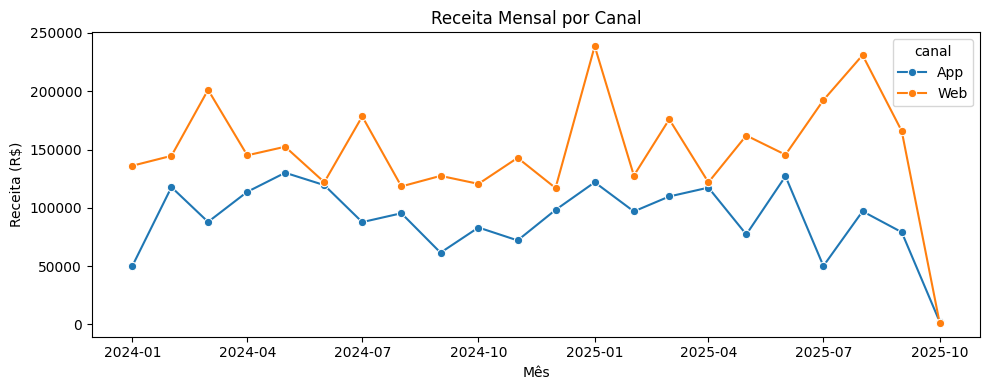

In [12]:
df_canal = (orders.groupby([orders['data_pedido'].dt.to_period('M').dt.to_timestamp(), 'canal'])
                   ['valor_liquido'].sum().reset_index(name='receita'))
plt.figure(figsize=(10,4))
sns.lineplot(data=df_canal, x='data_pedido', y='receita', hue='canal', marker='o')
plt.title('Receita Mensal por Canal'); plt.xlabel('Mês'); plt.ylabel('Receita (R$)')
plt.tight_layout();
plt.show()

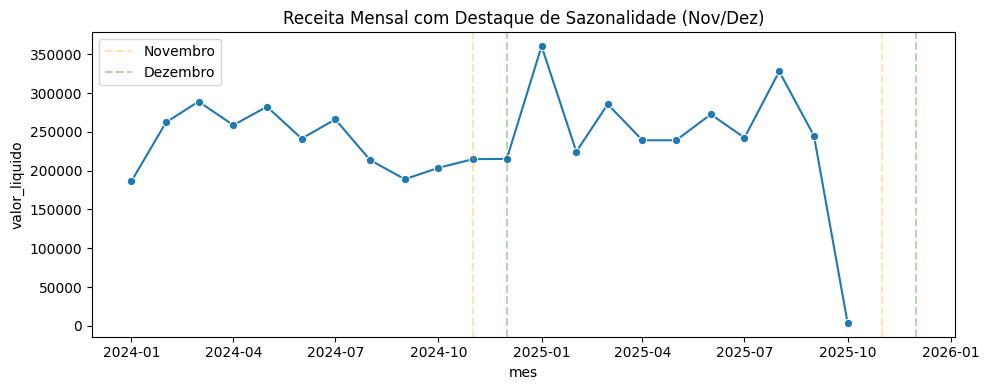

In [13]:
import datetime as dt

bf = [dt.datetime(year, 11, 29) for year in df_mensal['mes'].dt.year.unique()]  # prox. última sexta de nov (ajuste manual se quiser)
dia11 = [dt.datetime(year, 11, 11) for year in df_mensal['mes'].dt.year.unique()]

plt.figure(figsize=(10,4))
ax = sns.lineplot(data=df_mensal, x='mes', y='valor_liquido', marker='o')
for y in df_mensal['mes'].dt.year.unique():
    ax.axvline(pd.to_datetime(f'{y}-11-01'), color='orange', linestyle='--', alpha=0.3, label='Novembro' if y==df_mensal['mes'].dt.year.unique()[0] else '')
    ax.axvline(pd.to_datetime(f'{y}-12-01'), color='green', linestyle='--', alpha=0.3, label='Dezembro' if y==df_mensal['mes'].dt.year.unique()[0] else '')
ax.legend(loc='best')
ax.set_title('Receita Mensal com Destaque de Sazonalidade (Nov/Dez)')
plt.tight_layout(); plt.show()

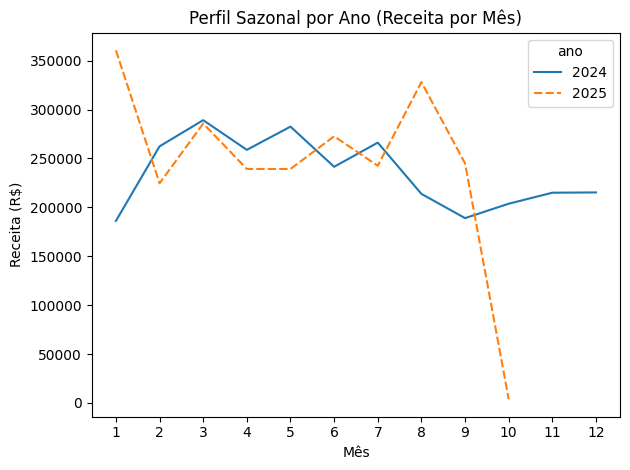

In [14]:
orders['ano'] = orders['data_pedido'].dt.year
orders['mes_num'] = orders['data_pedido'].dt.month
pivot_sazonal = (orders.groupby(['ano','mes_num'])['valor_liquido']
                        .sum()
                        .reset_index())
pivot_plot = pivot_sazonal.pivot(index='mes_num', columns='ano', values='valor_liquido')

sns.lineplot(data=pivot_plot)
plt.title('Perfil Sazonal por Ano (Receita por Mês)')
plt.xlabel('Mês'); plt.ylabel('Receita (R$)')
plt.xticks(range(1,13))
plt.tight_layout(); plt.show()

## 2. Como o canal (Web vs. App) impacta o ticket médio e a taxa de desconto?


In [15]:
# Colunas derivadas
orders = orders.copy()
orders['valor_liquido'] = orders['valor_bruto'] - orders['desconto']
orders['desconto_pct'] = (orders['desconto'] / orders['valor_bruto']).replace([pd.NA, pd.NaT], 0).fillna(0).clip(0, 1)

# Resumo por canal
resumo_canal = orders.groupby('canal').agg(
    ticket_medio=('valor_liquido', 'mean'),
    desconto_pct_medio=('desconto_pct', 'mean'),
    pedidos=('id_pedido', 'nunique')
).round(3).reset_index()

resumo_canal

,canal,ticket_medio,desconto_pct_medio,pedidos
0,App,2553.005,0.092,782
1,Web,2683.607,0.090,1218


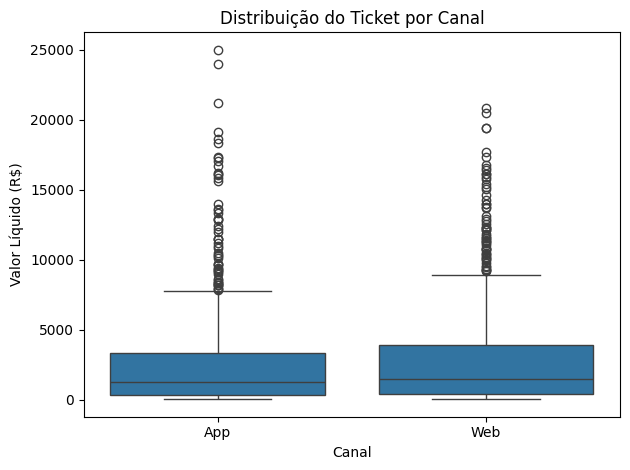

In [16]:
#Boxplot do ticket por canal (distribuição e outliers)
sns.boxplot(data=orders, x='canal', y='valor_liquido')
plt.title('Distribuição do Ticket por Canal')
plt.xlabel('Canal'); plt.ylabel('Valor Líquido (R$)')
plt.tight_layout(); plt.show()

/tmp/ipython-input-2440312373.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=resumo_canal, x='canal', y='ticket_medio', palette='Blues')


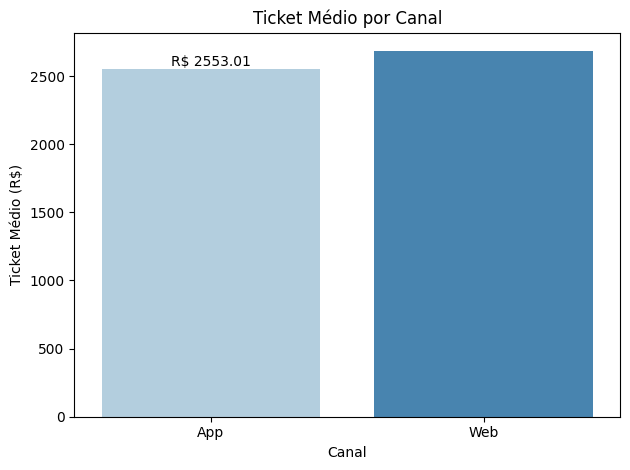

In [17]:
#Barras com o ticket médio por canal
ax = sns.barplot(data=resumo_canal, x='canal', y='ticket_medio', palette='Blues')
ax.bar_label(ax.containers[0], fmt='R$ %.2f')
plt.title('Ticket Médio por Canal')
plt.xlabel('Canal'); plt.ylabel('Ticket Médio (R$)')
plt.tight_layout(); plt.show()

/tmp/ipython-input-79246545.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=resumo_canal, x='canal', y='desconto_pct_medio', palette='Greens')


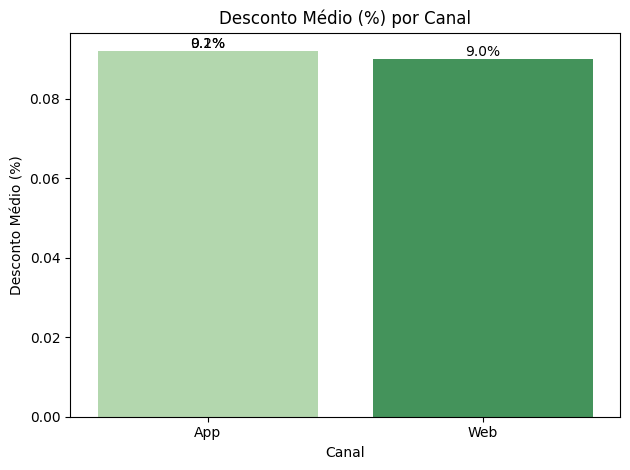

In [18]:
#Barras com a taxa média de desconto por canal
ax = sns.barplot(data=resumo_canal, x='canal', y='desconto_pct_medio', palette='Greens')
ax.bar_label(ax.containers[0], fmt='%.1f%%')
plt.title('Desconto Médio (%) por Canal')
plt.xlabel('Canal'); plt.ylabel('Desconto Médio (%)')
# converter para % no label
for c in ax.containers:
    ax.bar_label(c, labels=[f'{v*100:.1f}%' for v in c.datavalues])
plt.tight_layout(); plt.show()

## 3) Quais categorias e subcategorias mais contribuem para a receita e para o volume de pedidos?

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

orders = orders.copy()
orders['valor_liquido'] = orders['valor_bruto'] - orders['desconto']

# Receita por categoria
cat_receita = (orders.groupby('categoria')['valor_liquido']
                      .sum()
                      .sort_values(ascending=False)
                      .reset_index(name='receita'))

# Volume de pedidos por categoria
cat_pedidos = (orders.groupby('categoria')['id_pedido']
                      .nunique()
                      .sort_values(ascending=False)
                      .reset_index(name='num_pedidos'))

# Visualização: Top N por receita
topN = 10
top_cat = cat_receita.head(topN)

plt.figure(figsize=(8,4))
ax = sns.barplot(data=top_cat, x='valor_liquido', y='categoria', palette='Blues_r')
ax.set_title(f'Top {topN} Categorias por Receita')
ax.set_xlabel('Receita (R$)'); ax.set_ylabel('Categoria')
ax.bar_label(ax.containers[0], fmt='R$ %.0f')
plt.tight_layout(); plt.show()

# Visualização: Volume de pedidos por categoria
plt.figure(figsize=(8,4))
ax = sns.barplot(data=cat_pedidos, x='num_pedidos', y='categoria', palette='Greens_r')
ax.set_title('Volume de Pedidos por Categoria')
ax.set_xlabel('Nº de Pedidos'); ax.set_ylabel('Categoria')
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.tight_layout(); plt.show()

ValueError: Could not interpret value `valor_liquido` for `x`. An entry with this name does not appear in `data`.

<Figure size 800x400 with 0 Axes>

/tmp/ipython-input-1601120089.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_sub, x='receita', y='subcategoria', palette='Purples_r')


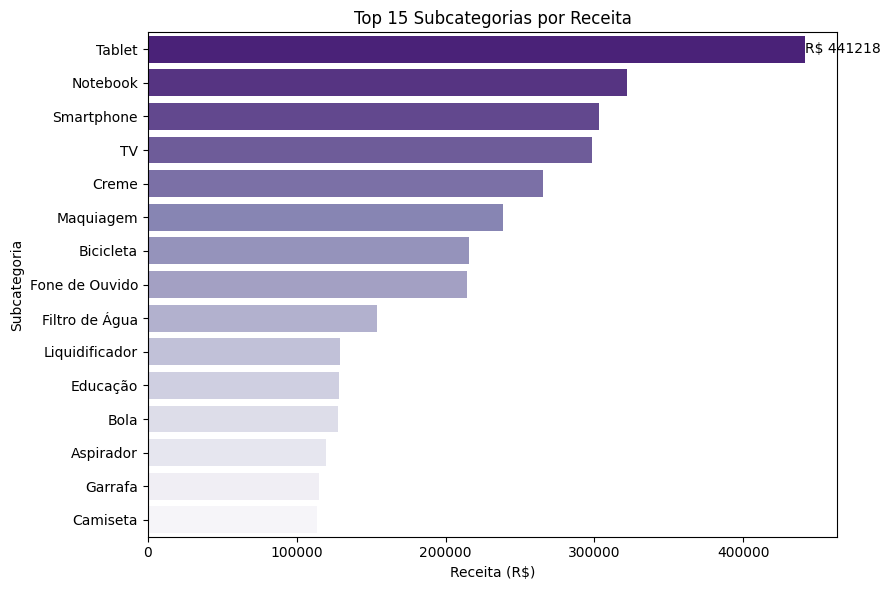

In [24]:
#2) Subcategorias: contribuição para receita e volume
# Receita por subcategoria
sub_receita = (orders.groupby(['categoria','subcategoria'])['valor_liquido']
                      .sum()
                      .sort_values(ascending=False)
                      .reset_index(name='receita'))

# Top N subcategorias por receita (independente da categoria)
top_sub = sub_receita.head(15)

plt.figure(figsize=(9,6))
ax = sns.barplot(data=top_sub, x='receita', y='subcategoria', palette='Purples_r')
ax.set_title('Top 15 Subcategorias por Receita')
ax.set_xlabel('Receita (R$)'); ax.set_ylabel('Subcategoria')
ax.bar_label(ax.containers[0], fmt='R$ %.0f')
plt.tight_layout(); plt.show()

/tmp/ipython-input-996763800.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_sub_itens, x='itens_vendidos', y='subcategoria', palette='Oranges_r')


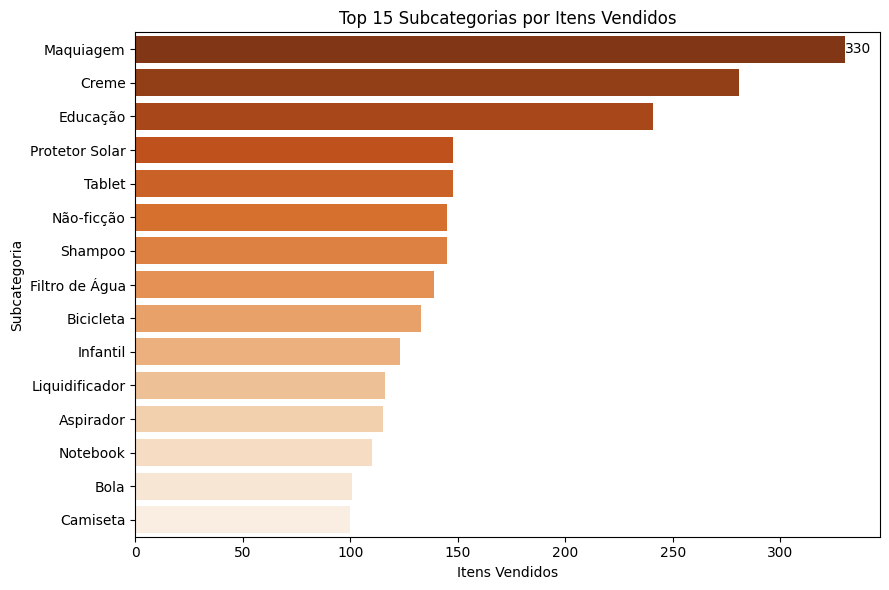

In [26]:
#3) Volume por subcategoria (itens vendidos)
# Merge para trazer categoria/subcategoria para itens
itens = order_items.merge(orders[['id_pedido','categoria','subcategoria']], on='id_pedido', how='left')

# Volume de itens por subcategoria
sub_itens = (itens.groupby(['categoria','subcategoria'])['quantidade']
                    .sum()
                    .sort_values(ascending=False)
                    .reset_index(name='itens_vendidos'))

top_sub_itens = sub_itens.head(15)

plt.figure(figsize=(9,6))
ax = sns.barplot(data=top_sub_itens, x='itens_vendidos', y='subcategoria', palette='Oranges_r')
ax.set_title('Top 15 Subcategorias por Itens Vendidos')
ax.set_xlabel('Itens Vendidos'); ax.set_ylabel('Subcategoria')
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.tight_layout(); plt.show()

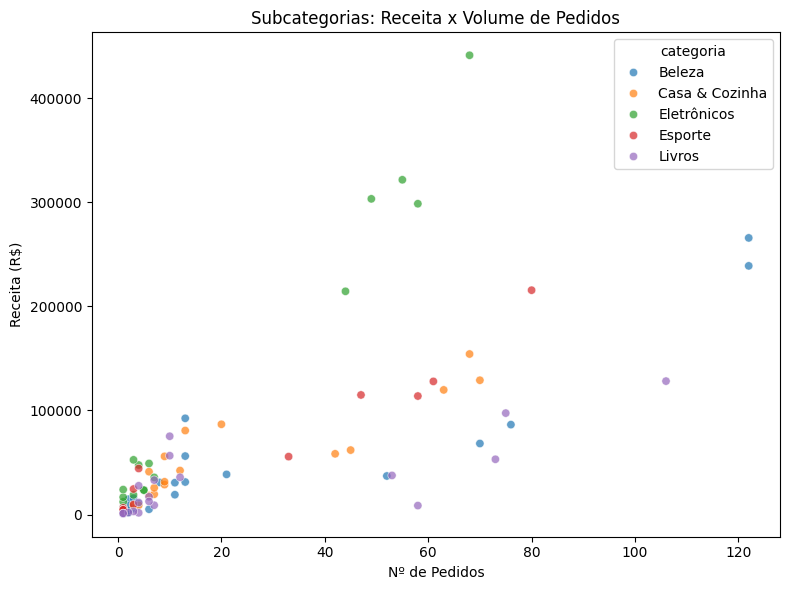

In [27]:
#4) Matriz receita x volume (trade-off)
sub_resumo = (orders.groupby(['categoria','subcategoria'])
                     .agg(receita=('valor_liquido','sum'),
                          pedidos=('id_pedido','nunique'))
                     .reset_index())
plt.figure(figsize=(8,6))
ax = sns.scatterplot(data=sub_resumo, x='pedidos', y='receita', hue='categoria', alpha=0.7)
plt.title('Subcategorias: Receita x Volume de Pedidos')
plt.xlabel('Nº de Pedidos'); plt.ylabel('Receita (R$)')
plt.tight_layout(); plt.show()

/tmp/ipython-input-3209311427.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_ticket, x='ticket_medio', y='subcategoria', palette='Greys_r')


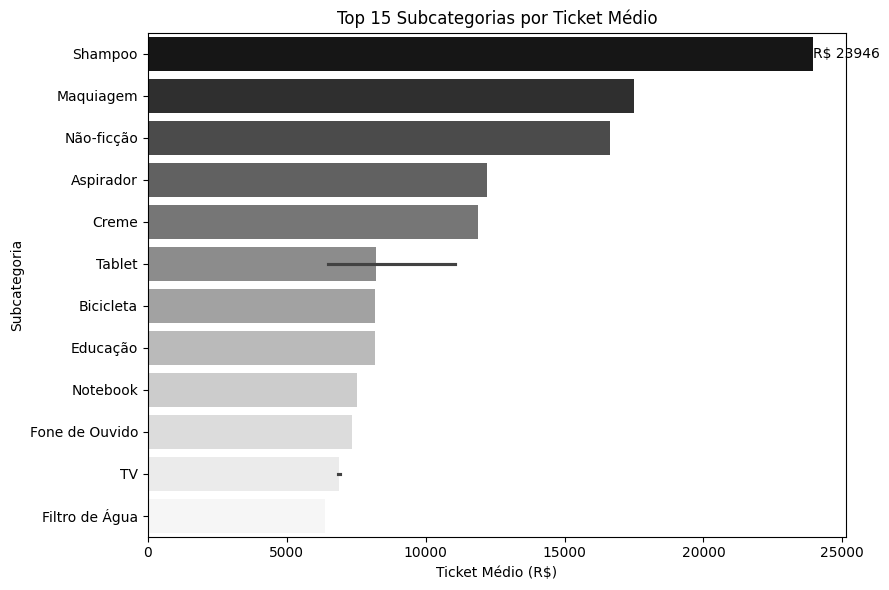

In [28]:
#5) Ticket médio por subcategoria (para explicar divergências)
sub_ticket = (orders.groupby(['categoria','subcategoria'])
                     .agg(ticket_medio=('valor_liquido','mean'),
                          receita=('valor_liquido','sum'))
                     .reset_index())
top_ticket = sub_ticket.sort_values('ticket_medio', ascending=False).head(15)

plt.figure(figsize=(9,6))
ax = sns.barplot(data=top_ticket, x='ticket_medio', y='subcategoria', palette='Greys_r')
ax.set_title('Top 15 Subcategorias por Ticket Médio')
ax.set_xlabel('Ticket Médio (R$)'); ax.set_ylabel('Subcategoria')
ax.bar_label(ax.containers[0], fmt='R$ %.0f')
plt.tight_layout(); plt.show()

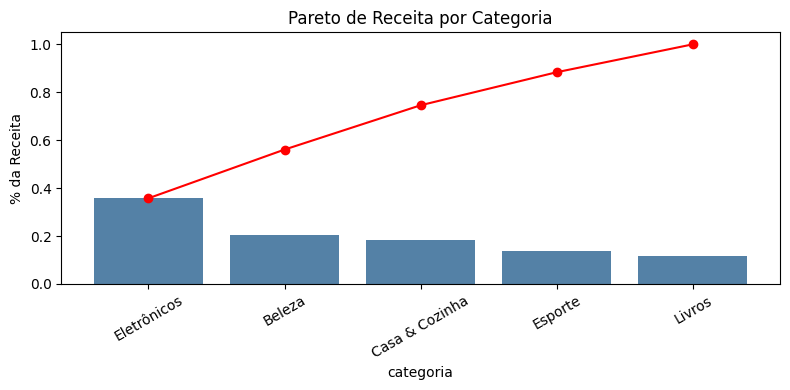

In [29]:
#6) Pareto (80/20) por categoria e subcategoria
df = cat_receita.copy()
df['pct_receita'] = df['receita'] / df['receita'].sum()
df = df.sort_values('receita', ascending=False)
df['acumulado'] = df['pct_receita'].cumsum()

plt.figure(figsize=(8,4))
sns.barplot(data=df, x='categoria', y='pct_receita', color='steelblue')
plt.plot(range(len(df)), df['acumulado'], color='red', marker='o')
plt.title('Pareto de Receita por Categoria'); plt.ylabel('% da Receita')
plt.xticks(rotation=30); plt.tight_layout(); plt.show()